In [86]:

import gpatlas
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import Dataset
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

import pandas as pd
from pathlib import Path
from typing import cast
import h5py
import time as tm
from datetime import datetime

In [87]:

#variables
n_phen=46
n_loci = 11623*2
n_alleles = 2
latent_space_g = 8000
EPS = 1e-15


batch_size = 128
num_workers = 3

base_file_name = 'BYxRM_'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

##########################################################################################

loaders = gpatlas.create_data_loaders(base_file_name, batch_size=128, num_workers=3, shuffle=True)

train_loader_geno = loaders['train_loader_geno']
test_loader_geno = loaders['test_loader_geno']

train_loader_pheno = loaders['train_loader_pheno']
test_loader_pheno = loaders['test_loader_pheno']

train_loader_gp = loaders['train_loader_gp']
test_loader_gp = loaders['test_loader_gp']

train_loader_gp_bv = loaders['train_loader_gp_bv']
test_loader_gp_bv = loaders['test_loader_gp_bv']


Using device: cuda


In [88]:
#residual based fully connected G -> P network
class GP_net_combi_rrblup(nn.Module):
    """
    Combined network using linear model predictions alongside raw genotype data

    Args:
        n_loci: #sites * #alleles
        latent_space_g: geno hidden layer size
        n_pheno: number of phenotypes to output/predict
        linear_model: pre-trained linear model for additive effects
    """
    def __init__(self, n_loci, latent_space_g, n_pheno, dropout_rate=0):
        super().__init__()
        batchnorm_momentum = 0.8

        # Adjusted input size to include phenotype predictions
        combined_input_size = n_loci + n_pheno

        # Modified network with concatenated input
        self.gpnet = nn.Sequential(
            nn.Linear(in_features=combined_input_size, out_features=latent_space_g),
            nn.BatchNorm1d(latent_space_g, momentum=batchnorm_momentum),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Dropout(dropout_rate),

            nn.Linear(in_features=latent_space_g, out_features=latent_space_g),
            nn.BatchNorm1d(latent_space_g, momentum=batchnorm_momentum),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Dropout(dropout_rate),

            nn.Linear(in_features=latent_space_g, out_features=n_pheno),
            nn.BatchNorm1d(n_pheno, momentum=batchnorm_momentum)
        )

    def forward(self, x, bv):
        # Get linear model predictions (additive effects)

        # Concatenate raw genotype data with linear predictions
        combined_input = torch.cat([x, bv], dim=1)

        # Get non-linear component prediction
        nonlinear_pred = self.gpnet(combined_input)

        # Final prediction combines linear and non-linear components
        # This represents: additive effects + non-additive effects (epistasis)
        #return linear_pred + nonlinear_pred
        return nonlinear_pred


In [89]:

def train_gpcombi(model, train_loader, test_loader=None,
                         n_loci=None,
                         n_alleles=2,
                         max_epochs=100,  # Set a generous upper limit
                         patience=10,      # Number of epochs to wait for improvement
                         min_delta=0.001, # Minimum change to count as improvement
                         learning_rate=0.0001, weight_decay=1e-5, device=device):
    """
    Train model with early stopping to prevent overtraining
    """
    # Move model to device
    model = model.to(device)

    # Initialize optimizer with proper weight decay
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )

    history = {
        'train_loss': [],
        'test_loss': [],
        'epochs_trained': 0
    }

    # Early stopping variables
    best_loss = float('inf')
    best_epoch = 0
    best_model_state = None
    patience_counter = 0

    # Training loop
    for epoch in range(max_epochs):
        # Training
        model.train()
        train_loss = 0

        for i, (phens, bv, gens) in enumerate(train_loader):

            phens = phens.to(device)
            bv = bv.to(device)

            gens = gens[:, : n_loci * n_alleles]
            gens = gens.to(device)

            phens_add = bv

            # Forward pass
            optimizer.zero_grad()
            output = model(gens, bv)

            # focal loss
            g_p_recon_loss = F.mse_loss(output + EPS, phens - (phens_add + EPS))

            # Backward and optimize
            g_p_recon_loss.backward()
            optimizer.step()

            train_loss += g_p_recon_loss.item()

        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation
        if test_loader is not None:
            model.eval() #disables dropout
            test_loss = 0

            with torch.no_grad():
                for phens, bv, gens in test_loader:
                    phens = phens.to(device)
                    bv = bv.to(device)
                    gens = gens[:, : n_loci * n_alleles]
                    gens = gens.to(device)

                    phens_add = bv

                    output = model(gens, bv)
                    test_loss += F.mse_loss(output + EPS, phens - (phens_add + EPS))

            avg_test_loss = test_loss / len(test_loader)
            history['test_loss'].append(avg_test_loss)

            print(f'Epoch: {epoch+1}/{max_epochs}, Train Loss: {avg_train_loss:.6f}, '
                  f'Test Loss: {avg_test_loss:.6f}')

            # Update learning rate
            scheduler.step(avg_test_loss)

            # Check for improvement
            if avg_test_loss < (best_loss - min_delta):
                best_loss = avg_test_loss
                best_epoch = epoch
                patience_counter = 0
                # Save best model state
                best_model_state = {k: v.cpu().detach().clone() for k, v in model.state_dict().items()}
                print(f"New best model at epoch {epoch+1} with test loss: {best_loss:.6f}")
            else:
                patience_counter += 1
                print(f"No improvement for {patience_counter} epochs (best: {best_loss:.6f})")

            # Early stopping check
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    # Record how many epochs were actually used
    history['epochs_trained'] = epoch + 1

    # Restore best model
    if best_model_state is not None:
        print(f"Restoring best model from epoch {best_epoch+1}")
        model.load_state_dict(best_model_state)

    return model, best_loss, history


In [97]:
model = GP_net_combi_rrblup(
    n_loci=n_loci,
    latent_space_g=latent_space_g,
    n_pheno=n_phen,
    dropout_rate=0.5)

model, best_loss_gp, history = train_gpcombi(model=model,
                                        train_loader=train_loader_gp_bv,
                                        test_loader=test_loader_gp_bv,
                                        n_loci=n_loci,
                                        device=device)
model.eval()

Epoch: 1/100, Train Loss: 1.472284, Test Loss: 1.400685
New best model at epoch 1 with test loss: 1.400685
Epoch: 2/100, Train Loss: 1.082851, Test Loss: 1.353484
New best model at epoch 2 with test loss: 1.353484
Epoch: 3/100, Train Loss: 0.902374, Test Loss: 1.364362
No improvement for 1 epochs (best: 1.353484)
Epoch: 4/100, Train Loss: 0.788982, Test Loss: 1.212679
New best model at epoch 4 with test loss: 1.212679
Epoch: 5/100, Train Loss: 0.685647, Test Loss: 1.125320
New best model at epoch 5 with test loss: 1.125320
Epoch: 6/100, Train Loss: 0.616819, Test Loss: 0.968239
New best model at epoch 6 with test loss: 0.968239
Epoch: 7/100, Train Loss: 0.561774, Test Loss: 0.935890
New best model at epoch 7 with test loss: 0.935890
Epoch: 8/100, Train Loss: 0.520215, Test Loss: 1.001319
No improvement for 1 epochs (best: 0.935890)
Epoch: 9/100, Train Loss: 0.494520, Test Loss: 0.974326
No improvement for 2 epochs (best: 0.935890)
Epoch: 10/100, Train Loss: 0.462727, Test Loss: 1.02024

GP_net_combi_rrblup(
  (gpnet): Sequential(
    (0): Linear(in_features=23292, out_features=8000, bias=True)
    (1): BatchNorm1d(8000, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=8000, out_features=8000, bias=True)
    (5): BatchNorm1d(8000, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01, inplace=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=8000, out_features=46, bias=True)
    (9): BatchNorm1d(46, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  )
)

In [98]:

residual_preds = []
true_phens = []
true_bv = []

with torch.no_grad():
    for phens, bv, gens in test_loader_gp_bv:
        gens = gens[:, : n_loci * n_alleles]
        bv = bv.to(device)
        phens = phens.to(device)
        gens = gens.to(device)

        # Get predictions
        resid_pred = model(gens, bv)
        full_pred = resid_pred + bv


        residual_preds.append(resid_pred.cpu().numpy())
        true_phens.append(phens.cpu().numpy())
        true_bv.append(bv.cpu().numpy())


In [99]:
residual_preds_all = np.vstack(residual_preds)
truepheno_preds_all = np.vstack(true_phens)
linear_preds_all = np.vstack(true_bv)

# Calculate full predictions
full_preds_all = residual_preds_all + linear_preds_all

# Calculate correlations for each phenotype
corrs_gp_combi = []
corrs_linear = []


for i in range(n_phen):
    corr, _ = pearsonr(truepheno_preds_all[:, i], full_preds_all[:, i])
    corrs_gp_combi.append(corr)

    corr_linear, _ = pearsonr(truepheno_preds_all[:, i], linear_preds_all[:, i])
    corrs_linear.append(corr_linear)


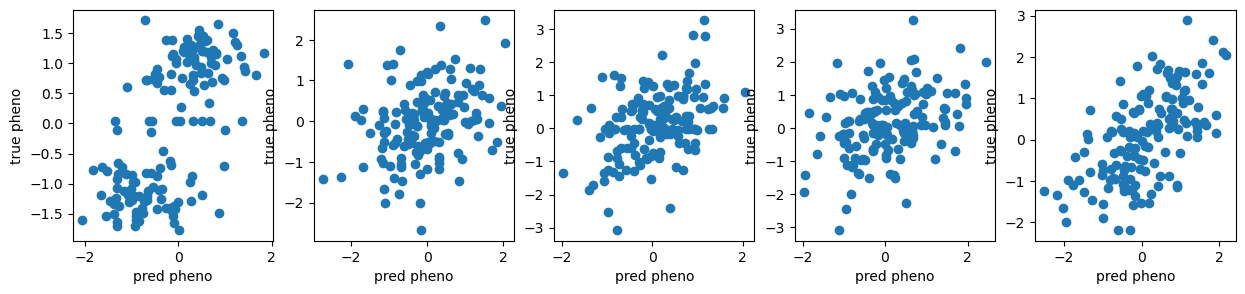

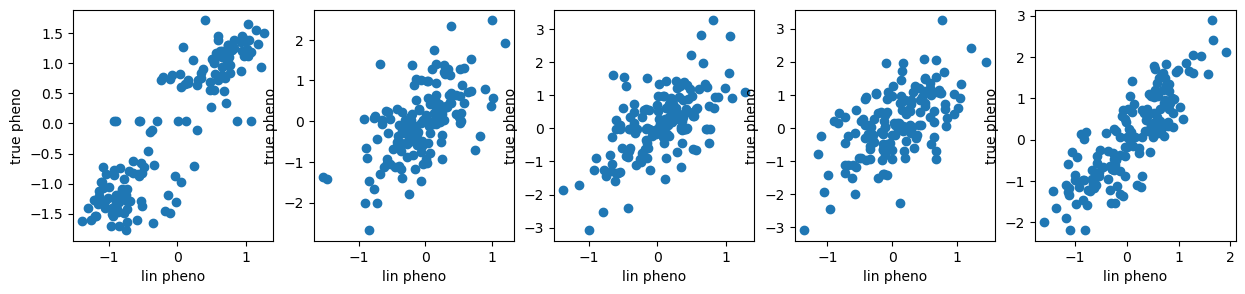

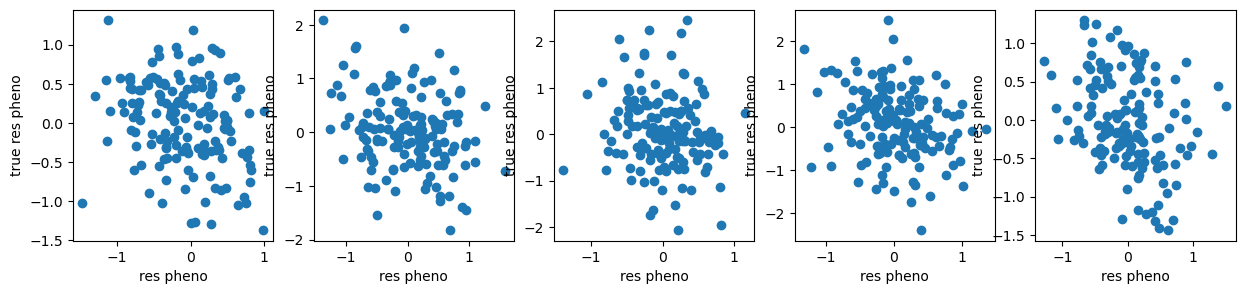

In [100]:
n_phen_plot = 5

fig, axes = plt.subplots(1, n_phen_plot, figsize=(n_phen_plot * 3, 3))

for i, ax in enumerate(axes):
    # Extract predictions for this phenotype
    fullpreds = linear_preds_all[:, i] + residual_preds_all[:, i]
    true_pheno = truepheno_preds_all[:, i]

    # Plot histogram
    ax.scatter(fullpreds, true_pheno)
    ax.set_xlabel('pred pheno')
    ax.set_ylabel('true pheno')


fig, axes = plt.subplots(1, 5, figsize=(n_phen_plot * 3, 3))

for i, ax in enumerate(axes):
    # Extract predictions for this phenotype
    linpreds = linear_preds_all[:, i]
    true_pheno = truepheno_preds_all[:, i]

    # Plot histogram
    ax.scatter(linpreds, true_pheno)
    ax.set_xlabel('lin pheno')
    ax.set_ylabel('true pheno')



fig, axes = plt.subplots(1, n_phen_plot, figsize=(n_phen_plot * 3, 3))

for i, ax in enumerate(axes):
    # Extract predictions for this phenotype
    respreds = residual_preds_all[:, i]
    true_res = truepheno_preds_all[:, i] - linear_preds_all[:, i]

    # Plot histogram
    ax.scatter(respreds, true_res)
    ax.set_xlabel('res pheno')
    ax.set_ylabel('true res pheno')


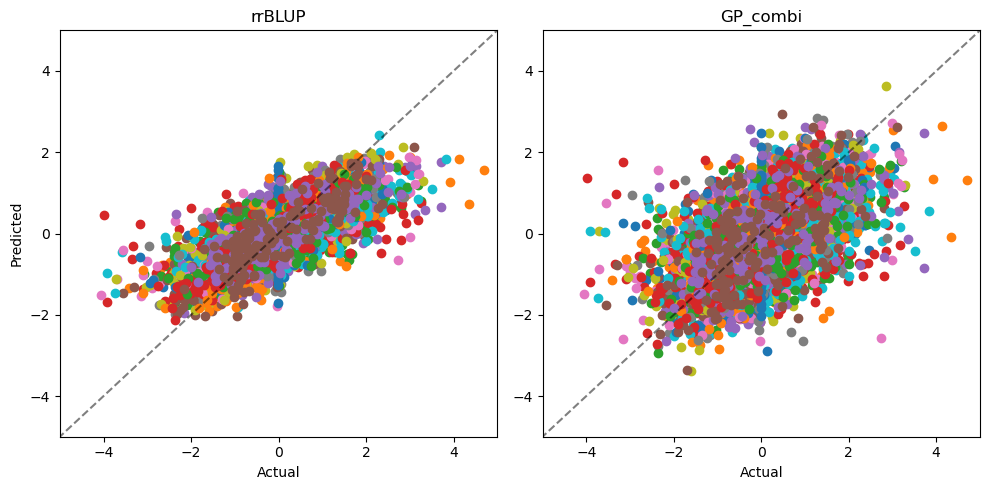

In [101]:
# Create a figure with two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Find global min and max for plot limits
min_val = -10
max_val = 5

# For the first subplot
for i in range(n_phen):
    # Get the true and predicted values for this phenotype
    true_vals = truepheno_preds_all[:, i]
    pred_vals = linear_preds_all[:, i]

    # Plot predicted vs actual (let matplotlib assign colors automatically)
    ax1.scatter(true_vals, pred_vals)

# Plot the perfect prediction line
ax1.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

# Set labels for first subplot
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set_title('rrBLUP')
ax1.set_xlim(-5, 5)
ax1.set_ylim(-5, 5)

# For the second subplot
for i in range(n_phen):
    # Get the true and predicted values for this phenotype
    true_vals = truepheno_preds_all[:, i]
    pred_vals = linear_preds_all[:, i]
    fullpreds = linear_preds_all[:, i] + residual_preds_all[:, i]

    # Plot predicted vs actual (let matplotlib assign colors automatically)
    ax2.scatter(true_vals, fullpreds)

# Plot the perfect prediction line
ax2.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

# Set labels for second subplot
ax2.set_xlabel('Actual')
ax2.set_title('GP_combi')
ax2.set_xlim(-5, 5)
ax2.set_ylim(-5, 5)
# Adjust layout to prevent overlap
plt.tight_layout()

In [102]:
len(corrs_gp_combi)


46

Text(0, 0.5, 'corrs_linear')

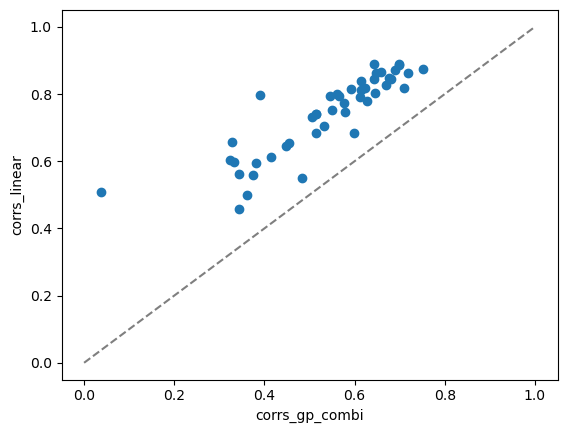

In [103]:

min_val = 0
max_val = 1

plt.scatter(corrs_gp_combi, corrs_linear)

# Plot the perfect prediction line
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

# Set labels for first subplot
plt.xlabel('corrs_gp_combi')
plt.ylabel('corrs_linear')
